# Setup

In [1]:
import os

import chemprop
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, TemplateAlign, rdDepictor, rdFMCS
from rdkit.Chem.Crippen import MolLogP
from scipy.stats import bootstrap, spearmanr, ttest_1samp, ttest_rel
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from tdc.benchmark_group import admet_group
from useful_rdkit_utils import rd_enable_svg

os.makedirs("figures", exist_ok=True)
rd_enable_svg()
np.random.seed(0)
sns.set_palette(
    [
        "#377C9E",
        "#F8AA70",
        "#AA3C65",
    ]
)
GRAY_COLOR = "#809092"
MOL_GRID_SUBIMAGE_SIZE = (300, 200)
np.random.seed(1)
# function to just return corr coef, for use in bootstrapping
spearmanr_stat = lambda x, y: spearmanr(x, y)[0]

In [2]:
TDC_microsome_splits = admet_group().get("Clearance_Microsome_AZ")
del TDC_microsome_splits["name"]

aliagas_benchmark = pd.read_csv(
    "https://static-content.springer.com/esm/art%3A10.1007%2Fs10822-015-9838-3/MediaObjects/10822_2015_9838_MOESM1_ESM.csv"
)

for df in TDC_microsome_splits.values():
    df["ROMol"] = df["Drug"].apply(Chem.MolFromSmiles)
    df["Y_log"] = df["Y"].apply(np.log)
aliagas_benchmark["ROMol"] = aliagas_benchmark["SMILES"].apply(Chem.MolFromSmiles)

Found local copy...


# Section 1
## Avoid Simpson's paradox

In [3]:
program_n = 50
program_sd = 2
program_means = np.array([6, 10, 14])
program_names = ["Program A", "Program B", "Program C"]
measured = np.hstack(
    [np.random.normal(m, program_sd, program_n) for m in program_means]
)
predicted = np.hstack(
    [np.random.normal(m, program_sd, program_n) for m in program_means]
)
program = np.hstack([[n] * program_n for n in program_names])
simpsons_df = pd.DataFrame(
    {"Measured": measured, "Predicted": predicted, "Program": program}
)

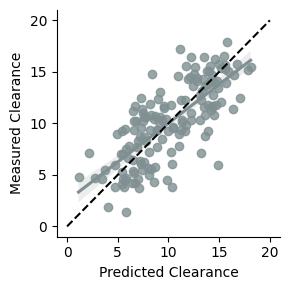

In [4]:
sns.lmplot(
    data=simpsons_df,
    x="Predicted",
    y="Measured",
    height=3,
    scatter_kws={"color": GRAY_COLOR},
    line_kws={"color": GRAY_COLOR},
)
plt.plot([0, 20], [0, 20], color="black", linestyle="--")
plt.xlabel("Predicted Clearance")
plt.ylabel("Measured Clearance")
plt.savefig("figures/simpsons_ungrouped.svg")

<Figure size 300x300 with 0 Axes>

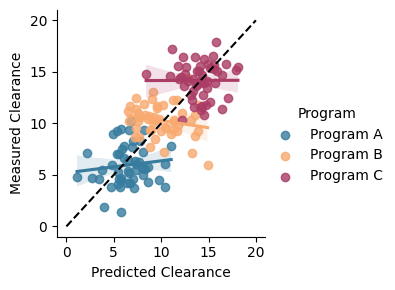

In [5]:
plt.figure(figsize=(3, 3))
sns.lmplot(data=simpsons_df, x="Predicted", y="Measured", hue="Program", height=3)
plt.plot([0, 20], [0, 20], color="black", linestyle="--")
plt.xlabel("Predicted Clearance")
plt.ylabel("Measured Clearance")
plt.savefig("figures/simpsons_grouped.svg")

In [6]:
print("Total spearmanr:", spearmanr(measured, predicted)[0])
for program in ["Program A", "Program B", "Program C"]:
    p = simpsons_df[simpsons_df["Program"] == program]
    print(f"{program}:", spearmanr(p["Measured"], p["Predicted"])[0])

Total spearmanr: 0.7486288279479089
Program A: 0.12326530612244897
Program B: -0.1733973589435774
Program C: 0.06304921968787515


## Miscalibrated vs uninformative models

In [7]:
measured = np.random.normal(10, 2, 50)
predicted_miscalibrated = measured + np.random.normal(0, 1, 50) + 5
predicted_uninformative = np.random.normal(10, 1, 50)
miscalibration_df = pd.DataFrame(
    {
        "measured": measured,
        "predicted_miscalibrated": predicted_miscalibrated,
        "predicted_uninformative": predicted_uninformative,
    }
)

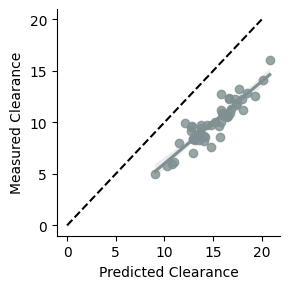

In [8]:
sns.lmplot(
    data=miscalibration_df,
    x="predicted_miscalibrated",
    y="measured",
    height=3,
    scatter_kws={"color": GRAY_COLOR},
    line_kws={"color": GRAY_COLOR},
)
plt.plot([0, 20], [0, 20], color="black", linestyle="--")
plt.xlabel("Predicted Clearance")
plt.ylabel("Measured Clearance")
plt.savefig("figures/miscalibration.svg")

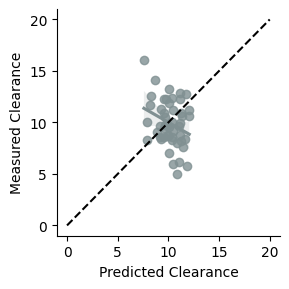

In [9]:
sns.lmplot(
    data=miscalibration_df,
    x="predicted_uninformative",
    y="measured",
    height=3,
    scatter_kws={"color": GRAY_COLOR},
    line_kws={"color": GRAY_COLOR},
)
plt.plot([0, 20], [0, 20], color="black", linestyle="--")
plt.xlabel("Predicted Clearance")
plt.ylabel("Measured Clearance")
plt.savefig("figures/uninformative.svg")

In [10]:
miscalibration_df.melt(
    id_vars=["measured"],
    value_vars=["predicted_miscalibrated", "predicted_uninformative"],
    value_name="prediction",
    var_name="model",
).groupby("model").apply(
    lambda x: pd.Series(
        {
            "Spearman R": spearmanr(x["measured"], x["prediction"])[0],
            "R2": r2_score(x["measured"], x["prediction"]),
            "MAE": np.mean(np.abs(x["measured"] - x["prediction"])),
        }
    )
)

,Spearman R,R2,MAE
model,,,
predicted_miscalibrated,0.865930,-4.366212,4.991799
predicted_uninformative,-0.195582,-0.540535,2.054979


# Section 2
## Data Exploration

In [11]:
# create fingerprints
TDC_microsome_fps = {}
TDC_microsome_fps_numpy = {}
for split, df in TDC_microsome_splits.items():
    TDC_microsome_fps[split] = [
        AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048) for m in df["ROMol"]
    ]
    TDC_microsome_fps_numpy[split] = np.array(TDC_microsome_fps[split])
aliagas_fps = [
    AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048)
    for m in aliagas_benchmark["ROMol"]
]
aliagas_fps_numpy = np.array(aliagas_fps)

In [12]:
# create similarity matrices
def get_similarity_array(fps_1, fps_2):
    return np.array([DataStructs.BulkTanimotoSimilarity(x, fps_1) for x in fps_2])


tdc_test_tdc_test_sim = get_similarity_array(
    TDC_microsome_fps["test"], TDC_microsome_fps["test"]
)
tdc_train_aliagas_sim = get_similarity_array(
    TDC_microsome_fps["train_val"], aliagas_fps
)
tdc_train_tdc_test_sim = get_similarity_array(
    TDC_microsome_fps["train_val"], TDC_microsome_fps["test"]
)
aliagas_aliagas_sim = get_similarity_array(aliagas_fps, aliagas_fps)

In [13]:
avg_num_sim = ((tdc_test_tdc_test_sim >= 0.5).sum(axis=0) - 1).mean()
print(
    f"Avg number of similar compounds within TDC test set to each TDC test compound: {avg_num_sim:.2f}"
)
avg_num_sim = (tdc_train_tdc_test_sim >= 0.5).sum(axis=1).mean()
print(
    f"Avg number of similar compounds within TDC train set to each TDC test compound: {avg_num_sim:.2f}"
)
avg_num_sim = ((tdc_train_tdc_test_sim >= 0.5).sum(axis=1) > 0).mean()
print(
    f"Proportion of TDC test compounds with a similar TDC train compound: {avg_num_sim:.2f}"
)

Avg number of similar compounds within TDC test set to each TDC test compound: 4.92
Avg number of similar compounds within TDC train set to each TDC test compound: 3.90
Proportion of TDC test compounds with a similar TDC train compound: 0.57


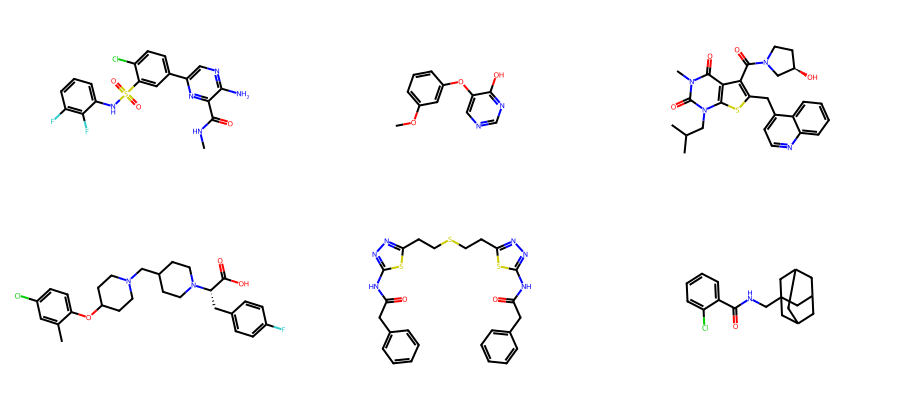

In [14]:
def display_and_save(svg, filename):
    with open(filename, "w") as f:
        f.write(svg.data)
    return svg


# Example TDC test compounds
display_and_save(
    Draw.MolsToGridImage(
        TDC_microsome_splits["test"]["ROMol"].sample(6, random_state=1),
        molsPerRow=3,
        subImgSize=MOL_GRID_SUBIMAGE_SIZE,
        useSVG=True,
    ),
    "figures/tdc_test_compounds.svg",
)

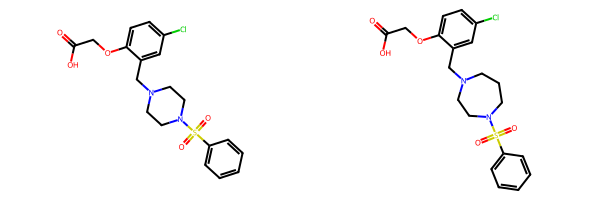

In [15]:
max_sim_index = np.unravel_index(
    tdc_train_tdc_test_sim.argmax(), tdc_train_tdc_test_sim.shape
)
# ensure molecules are aligned for plotting
mol1 = TDC_microsome_splits["test"]["ROMol"].iloc[max_sim_index[0]]
mol2 = TDC_microsome_splits["train_val"]["ROMol"].iloc[max_sim_index[1]]
mcs = rdFMCS.FindMCS(
    [mol1, mol2],
    completeRingsOnly=True,
    timeout=20,
)
template = Chem.MolFromSmarts(mcs.smartsString)
rdDepictor.Compute2DCoords(template)
rdDepictor.Compute2DCoords(mol1)
rdDepictor.Compute2DCoords(mol2)
TemplateAlign.AlignMolToTemplate2D(mol1, template, clearConfs=True)
TemplateAlign.AlignMolToTemplate2D(mol2, template, clearConfs=True)

# the most similar TDC train/test pair
display_and_save(
    Draw.MolsToGridImage(
        [
            mol1,
            mol2,
        ],
        molsPerRow=2,
        subImgSize=MOL_GRID_SUBIMAGE_SIZE,
        useSVG=True,
    ),
    "figures/most_similar_train_test.svg",
)

Sampled assays: ['CHEMBL1810825', 'CHEMBL2186144', 'CHEMBL1780338']


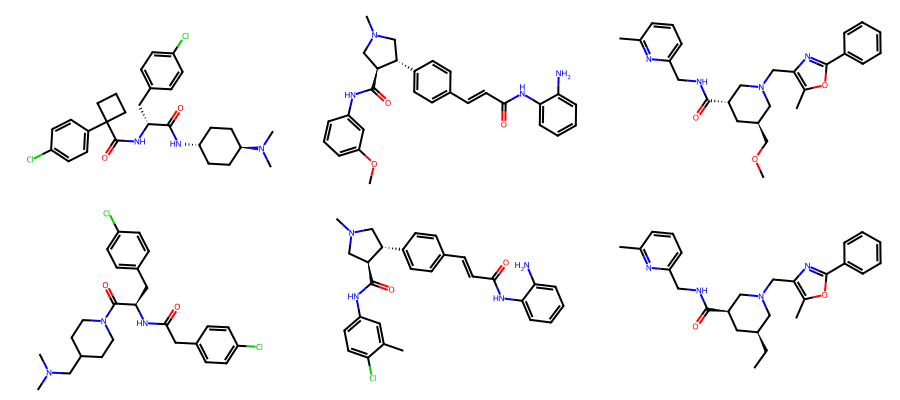

In [16]:
sampled_assays = pd.Series(aliagas_benchmark["ChEMBL Assay ID"].unique()).sample(
    3, random_state=0
)
sampled_compounds = []
for a in sampled_assays:
    sampled_compounds.extend(
        aliagas_benchmark[aliagas_benchmark["ChEMBL Assay ID"] == a]["ROMol"]
        .sample(2, random_state=0)
        .tolist()
    )
# reorder for drawing
sampled_compounds = sampled_compounds[::2] + sampled_compounds[1::2]
# example Aliagas compounds, grouped by assay ID
print("Sampled assays:", sampled_assays.tolist())
display_and_save(
    Draw.MolsToGridImage(
        sampled_compounds,
        molsPerRow=3,
        subImgSize=MOL_GRID_SUBIMAGE_SIZE,
        useSVG=True,
    ),
    "figures/aliagas_series.svg",
)

In [17]:
aliagas_assay_ids = aliagas_benchmark["ChEMBL Assay ID"].unique()
num_close_same_assay = []
num_close_different_assay = []
for aid in aliagas_assay_ids:
    selector = aliagas_benchmark["ChEMBL Assay ID"] == aid
    rows = aliagas_aliagas_sim[selector, :]
    same_assay = rows[:, selector]
    different_assay = rows[:, ~selector]
    num_close_same_assay.extend(((same_assay > 0.5).sum(axis=1) - 1))
    num_close_different_assay.extend(((different_assay > 0.5).sum(axis=1)))

print(
    f"Average number of similar same-assay compounds within Aliagas dataset: {np.mean(num_close_same_assay):.2f}"
)

Average number of similar same-assay compounds within Aliagas dataset: 24.51


In [18]:
tsne = TSNE(random_state=10)
tsne_out = tsne.fit_transform(
    np.vstack(
        [
            TDC_microsome_fps_numpy["train_val"],
            TDC_microsome_fps_numpy["test"],
            aliagas_fps_numpy,
        ],
    )
)
tsne_df = (
    pd.DataFrame(
        tsne_out,
        columns=["x", "y"],
        index=np.hstack(
            ["TDC train"] * len(TDC_microsome_fps_numpy["train_val"])
            + ["TDC test"] * len(TDC_microsome_fps_numpy["test"])
            + ["Aliagas"] * len(aliagas_fps_numpy)
        ),
    )
    .reset_index()
    .rename(columns={"index": "dataset"})
)

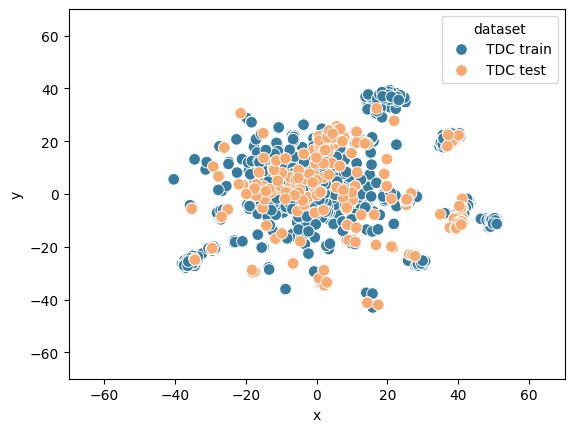

In [19]:
g = sns.scatterplot(
    data=tsne_df.query('dataset != "Aliagas"'),
    x="x",
    y="y",
    hue="dataset",
    s=70,
)
plt.xlim(-70, 70)
plt.ylim(-70, 70)
plt.savefig("figures/tsne_tdc_train_test.svg")

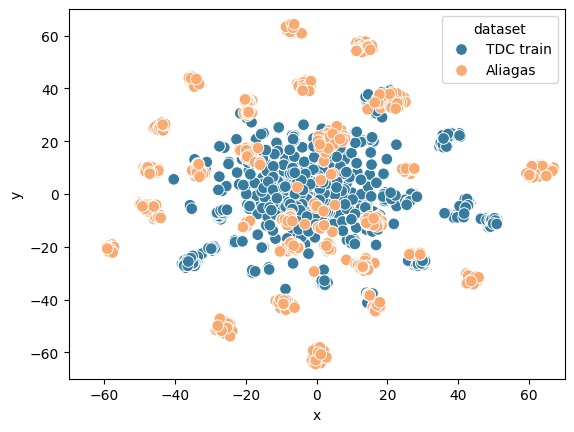

In [20]:
g = sns.scatterplot(
    data=tsne_df.query('dataset != "TDC test"'),
    x="x",
    y="y",
    hue="dataset",
    s=70,
)
plt.xlim(-70, 70)
plt.ylim(-70, 70)
plt.savefig("figures/tsne_tdc_aliagas.svg")

## Modeling

In [21]:
# create a version of the TDC train set that excludes compounds that are too similar to Aliagas compounds
tdc_train_exclusion_flags = tdc_train_aliagas_sim.max(axis=0) >= 0.5
TDC_microsome_splits["train_val_for_aliagas"] = (
    TDC_microsome_splits["train_val"][~tdc_train_exclusion_flags]
    .copy()
    .reset_index(drop=True)
)
TDC_microsome_fps["train_val_for_aliagas"] = [
    AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048)
    for m in TDC_microsome_splits["train_val_for_aliagas"]["ROMol"]
]
# save all TDC datasets in a ChemProp-compatible format
for key, value in TDC_microsome_splits.items():
    value["smiles"] = value["Drug"]
for key, value in TDC_microsome_splits.items():
    value[["smiles", "Y_log"]].to_csv(f"tdc_microsome_{key}.csv", index=False)

### TDC benchmark

In [22]:
svr = SVR(kernel="rbf", gamma=0.01, C=1)
svr.fit(TDC_microsome_fps["train_val"], TDC_microsome_splits["train_val"]["Y_log"])
svr_preds = svr.predict(TDC_microsome_fps["test"])

In [23]:
arguments = [
    "--data_path",
    "tdc_microsome_train_val.csv",
    "--separate_test_path",
    "tdc_microsome_test.csv",
    "--dataset_type",
    "regression",
    "--save_dir",
    "TDC_microsome_checkpoints",
    "--features_generator",
    "rdkit_2d_normalized",
    "--no_features_scaling",
    "--pytorch_seed",
    "0",
    "--seed",
    "0",
    "--quiet",
]
args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(
    args=args, train_func=chemprop.train.run_training
)

881it [00:00, 316449.59it/s]
100%|██████████| 881/881 [00:00<00:00, 269328.12it/s]
Fold 0
221it [00:00, 461394.32it/s]
100%|██████████| 30/30 [00:35<00:00,  1.17s/it]
Model 0 best validation rmse = 1.000471 on epoch 22
Model 0 test rmse = 1.066354                 
Ensemble test rmse = 1.066354
1-fold cross validation
	Seed 0 ==> test rmse = 1.066354
Overall test rmse = 1.066354 +/- 0.000000
Elapsed time = 0:00:56


In [24]:
arguments = [
    "--test_path",
    "tdc_microsome_test.csv",
    "--preds_path",
    "tdc_microsome_chemprop_preds.csv",
    "--checkpoint_dir",
    "TDC_microsome_checkpoints",
    "--features_generator",
    "rdkit_2d_normalized",
    "--no_features_scaling",
]

args = chemprop.args.PredictArgs().parse_args(arguments)
chemprop_preds = np.array(chemprop.train.make_predictions(args=args))[:, 0]

Loading training args
Setting molecule featurization parameters to default.
Loading data


221it [00:00, 364793.85it/s]
100%|██████████| 221/221 [00:04<00:00, 54.65it/s]


Validating SMILES
Test size = 221


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".


100%|██████████| 1/1 [00:42<00:00, 42.10s/it]

Saving predictions to tdc_microsome_chemprop_preds.csv
Elapsed time = 0:00:46


In [25]:
logp_preds = np.array([MolLogP(m) for m in TDC_microsome_splits["test"]["ROMol"]])

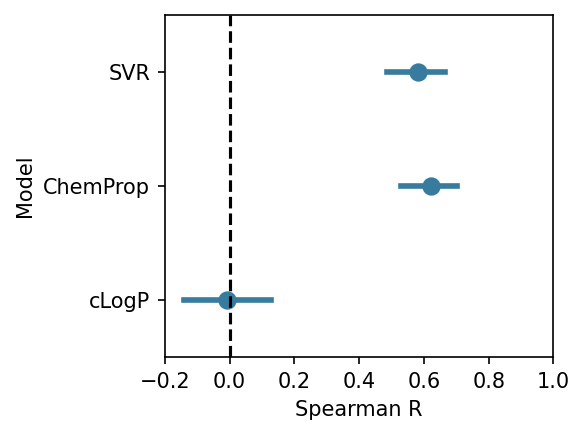

In [26]:
bootstrap_spearmanr_results = []
for p in [("SVR", svr_preds), ("ChemProp", chemprop_preds), ("cLogP", logp_preds)]:
    r = bootstrap(
        (p[1], TDC_microsome_splits["test"]["Y"]),
        spearmanr_stat,
        vectorized=False,
        paired=True,
    ).bootstrap_distribution
    bootstrap_spearmanr_results.append(pd.DataFrame({"Model": p[0], "Spearman R": r}))
bootstrap_spearmanr_results = pd.concat(bootstrap_spearmanr_results)

plt.figure(figsize=(4, 3), dpi=150)
sns.pointplot(
    data=bootstrap_spearmanr_results,
    y="Model",
    x="Spearman R",
    join=False,
    errorbar=("pi", 95),
)
plt.axvline(0, linestyle="--", color="black")
plt.xlim(-0.2, 1)
plt.tight_layout()
plt.savefig("figures/tdc_train_test_results.svg", bbox_inches="tight")

### Aliagas benchmark

In [27]:
svr_aliagas = SVR(kernel="rbf", gamma=0.01, C=1)
svr_aliagas.fit(
    TDC_microsome_fps["train_val_for_aliagas"],
    TDC_microsome_splits["train_val_for_aliagas"]["Y_log"],
)
aliagas_svr_preds = svr_aliagas.predict(aliagas_fps)

In [28]:
aliagas_benchmark["smiles"] = aliagas_benchmark["SMILES"]
aliagas_benchmark[["smiles"]].to_csv("aliagas_smiles.csv", index=False)

In [29]:
arguments = [
    "--data_path",
    "tdc_microsome_train_val_for_aliagas.csv",
    "--separate_test_path",
    "tdc_microsome_test.csv",  # (we'll eval on aliagas in later cells)
    "--dataset_type",
    "regression",
    "--save_dir",
    "aliagas_microsome_checkpoints",
    "--features_generator",
    "rdkit_2d_normalized",
    "--no_features_scaling",
    "--pytorch_seed",
    "0",
    "--seed",
    "0",
    "--quiet",
]
args = chemprop.args.TrainArgs().parse_args(arguments)
_ = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)

811it [00:00, 327799.99it/s]
100%|██████████| 811/811 [00:00<00:00, 238306.05it/s]
Fold 0
221it [00:00, 457522.80it/s]
100%|██████████| 30/30 [00:32<00:00,  1.09s/it]
Model 0 best validation rmse = 1.007749 on epoch 28
Model 0 test rmse = 1.102012                 
Ensemble test rmse = 1.102012
1-fold cross validation
	Seed 0 ==> test rmse = 1.102012
Overall test rmse = 1.102012 +/- 0.000000
Elapsed time = 0:00:52


In [30]:
arguments = [
    "--test_path",
    "aliagas_smiles.csv",
    "--preds_path",
    "aliagas_chemprop_preds.csv",
    "--checkpoint_dir",
    "aliagas_microsome_checkpoints",
    "--features_generator",
    "rdkit_2d_normalized",
    "--no_features_scaling",
]

args = chemprop.args.PredictArgs().parse_args(arguments)
aliagas_chemprop_preds = chemprop.train.make_predictions(args=args)

Loading training args
Setting molecule featurization parameters to default.
Loading data


972it [00:00, 459364.90it/s]
100%|██████████| 972/972 [00:17<00:00, 54.11it/s]


Validating SMILES
Test size = 972


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".


100%|██████████| 1/1 [00:57<00:00, 57.85s/it]

Saving predictions to aliagas_chemprop_preds.csv
Elapsed time = 0:01:16


In [31]:
aliagas_analysis_df = aliagas_benchmark[["smiles", "ROMol", "ChEMBL Assay ID"]].copy()
aliagas_analysis_df["Y"] = aliagas_benchmark["Conversion HLM pCLh mL/min/kg"]
aliagas_analysis_df["SVR"] = aliagas_svr_preds
aliagas_analysis_df["ChemProp"] = [x[0] for x in aliagas_chemprop_preds]
aliagas_analysis_df["cLogP"] = [MolLogP(m) for m in aliagas_benchmark["ROMol"]]
aliagas_analysis_df["GeneSVR"] = aliagas_benchmark["Model pCLh mL/min/kg"]

aliagas_analysis_df = aliagas_analysis_df.melt(
    id_vars=["smiles", "ROMol", "ChEMBL Assay ID", "Y"],
    value_vars=["ChemProp", "SVR", "cLogP", "GeneSVR"],
    var_name="Model",
    value_name="Prediction",
)

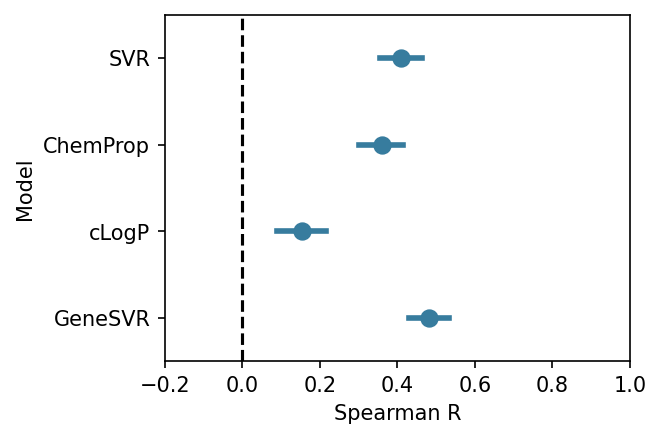

In [32]:
bootstrap_spearmanr_results = []
for m in ["SVR", "ChemProp", "cLogP", "GeneSVR"]:
    d = aliagas_analysis_df[aliagas_analysis_df["Model"] == m]
    r = bootstrap(
        (d["Prediction"], d["Y"]), spearmanr_stat, vectorized=False, paired=True
    ).bootstrap_distribution
    bootstrap_spearmanr_results.append(pd.DataFrame({"Model": m, "Spearman R": r}))
bootstrap_spearmanr_results = pd.concat(bootstrap_spearmanr_results)

plt.figure(figsize=(4, 3), dpi=150)
sns.pointplot(
    data=bootstrap_spearmanr_results,
    y="Model",
    x="Spearman R",
    join=False,
    errorbar=("pi", 95),
)
plt.axvline(0, linestyle="--", color="black")
plt.xlim(-0.2, 1)
plt.savefig("figures/aliagas_pooled_results.svg", bbox_inches="tight")

In [33]:
aliagas_global_results = (
    aliagas_analysis_df.groupby("Model")
    .apply(lambda x: spearmanr(x["Prediction"], x["Y"])[0])
    .reset_index()
    .rename(columns={0: "Spearman R"})
)
aliagas_global_results

,Model,Spearman R
0,ChemProp,0.359320
1,GeneSVR,0.482830
2,SVR,0.410835
3,cLogP,0.154455


In [34]:
aliagas_grouped_assay_level_results = (
    aliagas_analysis_df.groupby(["Model", "ChEMBL Assay ID"])
    .apply(lambda x: spearmanr(x["Prediction"], x["Y"])[0])
    .reset_index()
    .rename(columns={0: "Spearman R"})
)
aliagas_grouped_assay_level_pivot = aliagas_grouped_assay_level_results.pivot(
    index="ChEMBL Assay ID", columns="Model", values="Spearman R"
).query(
    '`ChEMBL Assay ID`.ne("CHEMBL1777317")'
)  # remove CHEMBL1777317, which has only 1 compound

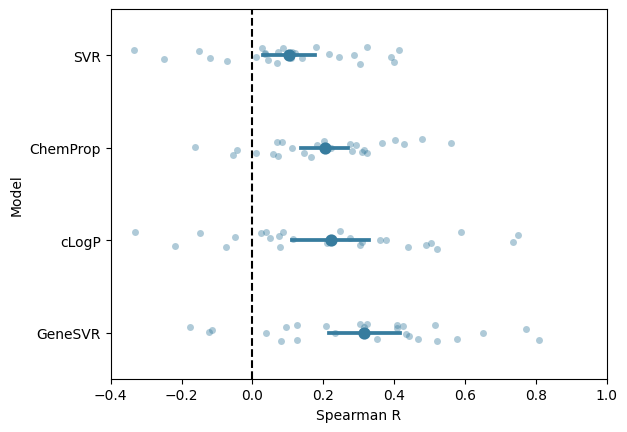

In [35]:
aliagas_grouped_assay_level_results["Model"] = pd.Categorical(
    aliagas_grouped_assay_level_results["Model"],
    categories=["SVR", "ChemProp", "cLogP", "GeneSVR"],
)
sns.stripplot(
    data=aliagas_grouped_assay_level_results,
    y="Model",
    x="Spearman R",
    dodge=True,
    alpha=0.4,
)
sns.pointplot(
    data=aliagas_grouped_assay_level_results,
    y="Model",
    x="Spearman R",
    join=False,
    errorbar=("se", 1.96),
)
plt.axvline(0, linestyle="--", color="black")
plt.xlim(-0.4, 1)
plt.savefig("figures/aliagas_assay_level_results.svg", bbox_inches="tight")

In [36]:
for model in ["SVR", "ChemProp", "GeneSVR"]:
    print(f"{model} vs. cLogP")
    print(
        ttest_rel(
            aliagas_grouped_assay_level_pivot[model],
            aliagas_grouped_assay_level_pivot["cLogP"],
        )
    )

SVR vs. cLogP
TtestResult(statistic=-1.9286333812960839, pvalue=0.06520518393471564, df=25)
ChemProp vs. cLogP
TtestResult(statistic=-0.32679924446131803, pvalue=0.7465401276883679, df=25)
GeneSVR vs. cLogP
TtestResult(statistic=1.4934061992095622, pvalue=0.14784548249593735, df=25)


In [37]:
for model in ["SVR", "ChemProp", "GeneSVR", "cLogP"]:
    print(f"{model} vs. 0")
    print(ttest_1samp(aliagas_grouped_assay_level_pivot[model], 0))

SVR vs. 0
TtestResult(statistic=2.7432265949090207, pvalue=0.011087715553650257, df=25)
ChemProp vs. 0
TtestResult(statistic=5.9432267106795615, pvalue=3.3295517857075306e-06, df=25)
GeneSVR vs. 0
TtestResult(statistic=6.202559483293209, pvalue=1.735461221386764e-06, df=25)
cLogP vs. 0
TtestResult(statistic=3.9870208401767835, pvalue=0.0005122333268858725, df=25)
